In [573]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, recall_score, precision_score, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from datetime import date
import warnings
import shap
import seaborn as sns
import pickle

In [574]:
%load_ext autoreload
%autoreload 2
from library import set_seed, make_dataloader, split_and_standardize, LogMLP, LogSEANN, ModelWrapper, train_model, train_custom_model, predict
from library import columns_with_low_value_counts, alternative_custom_loss_or, compute_scaling_weights_binary_classif, create_constraints
from library import sigmoid, compute_log_scaling_weights, compute_linear_scaling_weights, ln_normalize, linear_normalize
from library import compare_deepshap_dashboard, plot_deepshap_response_function, compare_deepshap_response_function
import torch
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cpu device


In [ ]:
# load data
features = pd.read_csv("../data/GCAT/features.csv", sep=',', na_values='NA')
outcome = pd.read_csv("../data/GCAT/outcome.csv", sep=',', na_values='NA')

## Train reference model

In [547]:
# split data
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size = 1 - train_ratio, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0, shuffle=True)

In [556]:
# Data standardisation
categorical_columns_list = columns_with_low_value_counts(X_train, 2)

std_X_train, std_X_valid, std_X_test = X_train.copy(deep=True), X_valid.copy(deep=True), X_test.copy(deep=True)
columns_to_standardize = [col for col in list(std_X_train.columns) if col not in categorical_columns_list]

train_mean = X_train[columns_to_standardize].mean()
train_std = X_train[columns_to_standardize].std()
std_X_train[columns_to_standardize] = (X_train[columns_to_standardize] - train_mean) / train_std
std_X_valid[columns_to_standardize] = (X_valid[columns_to_standardize] - train_mean) / train_std
std_X_test[columns_to_standardize] = (X_test[columns_to_standardize] - train_mean) / train_std

LogMLP(
  (input_layer): Sequential(
    (0): Linear(in_features=99, out_features=89, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (hidden_layers): Sequential(
    (linear_1): Linear(in_features=89, out_features=8, bias=True)
    (LK_1): LeakyReLU(negative_slope=0.01)
    (linear_2): Linear(in_features=8, out_features=2, bias=True)
    (LK_2): LeakyReLU(negative_slope=0.01)
    (linear_3): Linear(in_features=2, out_features=2, bias=True)
    (LK_3): LeakyReLU(negative_slope=0.01)
  )
  (output_layer): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


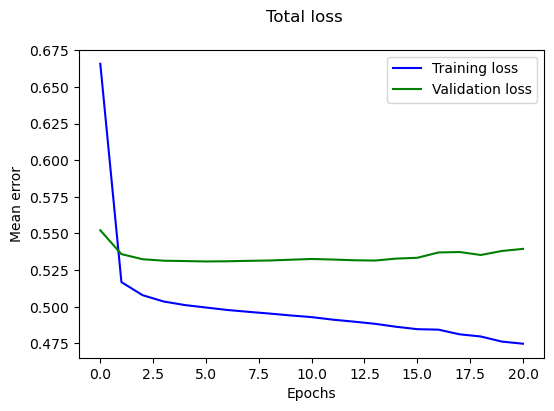

MLP accuracy: 0.7530536378120021 :  ROC AUC: 0.7029198222397905
Precision: 0.5833333333333334 Recall: 0.06645569620253164
0.0    3658
1.0     108
dtype: int64


In [558]:
train_dataloader = make_dataloader(std_X_train, y_train, dtype=torch.float64)
valid_dataloader = make_dataloader(std_X_valid, y_valid, dtype=torch.float64)
test_dataloader = make_dataloader(std_X_test, y_test, dtype=torch.float64)

# 1. train MLP
set_seed(0)
mlp = LogMLP(n_features=len(X_train.columns),
             initial_size_multiplier=best_params['initial_size_multiplier'],
             n_hidden_layers=best_params['n_hidden_layers'],
             size_decrease_multiplier=best_params['size_decrease_multiplier']).double().to(device)
print(mlp)
bce = torch.nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr = best_params['learning_rate'])
train_model(mlp, bce, optimizer, train_dataloader, valid_dataloader, device, verbose=False, plot=True, epochs=100)

# predict
pred_probas = predict(test_dataloader, mlp, device)
auc = roc_auc_score(y_test, pred_probas)
score = accuracy_score(y_test, pred_probas.round())
print(f"MLP accuracy:", score, ":  ROC AUC:", auc)
print("Precision:", precision_score(y_test, pred_probas.round()), "Recall:", recall_score(y_test, pred_probas.round()))
dist = pd.Series(pred_probas.round()).value_counts()
print(dist)

In [559]:
# compute shapley values
max_sample_size=1000 # adjust max sample size for shap background dataset
from library import ModelWrapper
wrapped_model = ModelWrapper(mlp)
background_data = []
sample_size=0
for inputs, targets in test_dataloader:
    sample_size += inputs.shape[0]
    if sample_size <= max_sample_size:
        background_data.append(inputs)
    else:
        break
background_tensor = torch.cat(background_data, dim=0)  # Concatenate along the batch dimension
print(background_tensor.shape)

explainer = shap.DeepExplainer(wrapped_model, background_tensor)
mlp_shap_values = explainer.shap_values(background_tensor)

torch.Size([960, 99])


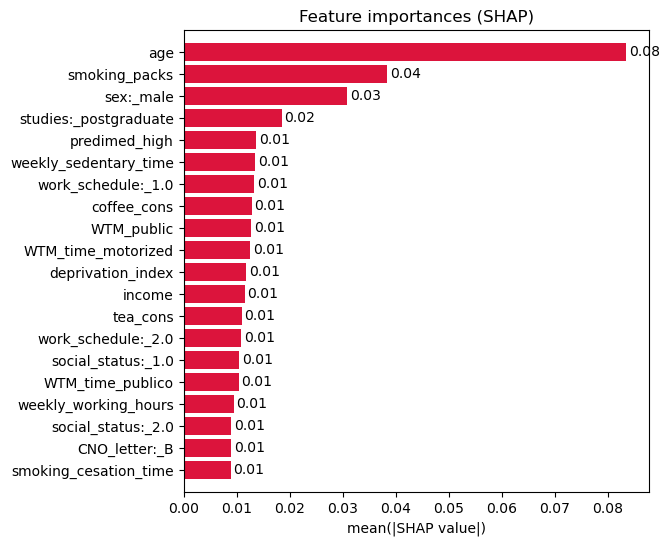

In [560]:
# plot shap feature importance
feature_names = list(X_test.columns)
n_features = 20
fig, (ax) = plt.subplots(1, 1, figsize=(6, n_features//3))
importances = [np.mean(abs(mlp_shap_values[:,i])) for i in range(len(mlp_shap_values[0]))]
indices = np.argsort(importances)[::-1]
sorted_importances = [importances[indice] for indice in indices]
sorted_labels = [feature_names[indice] for indice in indices]

ax.set_title("Feature importances (SHAP)")
ax.barh(range(len(sorted_importances[:n_features])), sorted_importances[:n_features][::-1], color="crimson", align="center")
ax.set_yticks(ticks=range(len(sorted_importances[:n_features])))
ax.set_yticklabels(sorted_labels[:n_features][::-1], fontsize=10)
ax.set_ylim([-1, len(sorted_importances[:n_features])])
ax.set_xlabel("mean(|SHAP value|)")
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:.2f}' for x in container.datavalues], padding=2)
plt.show()

# Implements SEANN

In [561]:
pes = {
    "smoking_habit:_smoker": np.log(1.13), # Binary variables are not standardized
    "UBE_per_week": np.log(1.06) / ((7*10)/8) * np.std(X_train["UBE_per_week"]), # 1 UBE = 10g/d increment. We convert litterature extracted log odds into stdardized log odds.
    "predimed_high": np.log(0.87),
    "weekly_sedentary_time": np.log(1.04) / 7 * np.std(X_train["weekly_sedentary_time"]), # RR in hour/day, converting into h/weeks
    "sports_metw": np.log(0.94)/10 * np.std(X_train['sports_metw']), # Given RR for 10Met H/w. Convert into 1met h/w increase.
    "ndvi": np.log(0.97) * 10 * np.std(X_train["ndvi"]), # given OR for 0.1 unit per increments
    "no2": np.log(1.05)/10 * np.std(X_train['no2']), # 10 μg/m3 increments in both litterature and data
    "pm25": np.log(1.1)/10 * np.std(X_train['pm25']),
    "o3": np.log(1.05)/10 * np.std(X_train['o3']),
    "deprivation_index": np.log(1.139) * np.std(X_train['deprivation_index']), # RR 1.139 conerverted into OR
    "traffic_noise_days": np.log(1.018) / 10 * np.std(X_train['traffic_noise_days']), # given RR for 10 db increase. Convert into 1 db increase
       }
pes_indexes = dict(zip([std_X_train.columns.get_loc(c) for c in pes.keys()], pes.values()))
pes_sample_sizes = {
    "smoking_habit:_smoker": 250741, 
    "UBE_per_week": 414477,
    "predimed_high": 59001,
    "weekly_sedentary_time": 367264,
    "sports_metw": 330222,
    "ndvi": int(100e6),
    "no2": 29274,
    "pm25": 20006,
    "o3": 27783,
    "deprivation_index": int(62e6), 
    "traffic_noise_days": 5514555,
       }
pes

{'smoking_habit:_smoker': 0.12221763272424911,
 'UBE_per_week': 0.04732606793195113,
 'predimed_high': -0.13926206733350766,
 'weekly_sedentary_time': 0.056592175679406276,
 'sports_metw': -0.04247308843112187,
 'ndvi': -0.022904816027674416,
 'no2': 0.05087520755357427,
 'pm25': 0.014419190464586343,
 'o3': 0.03065989752090177,
 'deprivation_index': 0.09426159858212063,
 'traffic_noise_days': 0.009333391779597449}

In [562]:
# create ground truth shapley values

# create a background dataset to compute shapley values
max_sample_size=1000 # adjust max sample size for shap background dataset (greatly impacts computation time)
background_data = []
sample_size=0
for inputs, targets in test_dataloader:
    sample_size += inputs.shape[0]
    if sample_size <= max_sample_size:
        background_data.append(inputs)
    else:
        break
background_tensor = torch.cat(background_data, dim=0)  # Concatenate along the batch dimension
print(background_tensor.shape)

true_shap_values = {}
inputs = background_tensor.detach().clone().numpy()
inputs = pd.DataFrame(inputs, columns=feature_names)
for i, col in enumerate(list(pes.keys())):
    X = inputs[[col]]
    model = LogisticRegression()
    model.fit(X, np.random.choice([0, 1], size=inputs.shape[0]-2, replace=True).tolist() + [0, 1]) # fit just to prevent a bug in scikit learn..
    model.intercept_ = 0
    model.coef_ = np.array([[pes[col]]]) # replace coeff by litterature extracted coeff
    explainer = shap.Explainer(model.predict_proba, X)
    true_shap = explainer(X)
    true_shap_values[col] = true_shap.values[:, 0, 1]

torch.Size([960, 99])


In [564]:
# Construct the list of constraints.
indexes = list(pes_indexes.keys())
effect_sizes = list(pes.values())
step_sizes = [0.1 for i in range(len(indexes))]
name_list = list(pes.keys())

importance_mult = 0.050
weights = linear_normalize(list(pes_sample_sizes.values()))
standard_weights = compute_scaling_weights_binary_classif(std_X_train, y_train, indexes, effect_sizes,  step_sizes)
predictive_weight = standard_weights[0] * importance_mult
constraints_weights = [standard_weights[i+1] * weights[i] * (1-importance_mult) for i in range(len(weights))]
constraints = create_constraints(indexes, effect_sizes, step_sizes, constraints_weights, name_list)

Constraint Name: smoking_habit:_smoker     | Index: 63    | Effect Size: 0.1222     | Step size: 0.1        | Weight: 151.19186017782695
Constraint Name: UBE_per_week              | Index: 7     | Effect Size: 0.0473     | Step size: 0.1        | Weight: 1666.1126926568766
Constraint Name: predimed_high             | Index: 98    | Effect Size: -0.1393    | Step size: 0.1        | Weight: 27.419178241270433
Constraint Name: weekly_sedentary_time     | Index: 14    | Effect Size: 0.0566     | Step size: 0.1        | Weight: 1032.9521412727065
Constraint Name: sports_metw               | Index: 10    | Effect Size: -0.0425    | Step size: 0.1        | Weight: 1647.7403430355391
Constraint Name: ndvi                      | Index: 28    | Effect Size: -0.0229    | Step size: 0.1        | Weight: 1714679.202020496
Constraint Name: no2                       | Index: 29    | Effect Size: 0.0509     | Step size: 0.1        | Weight: 101.84830119185568
Constraint Name: pm25                     

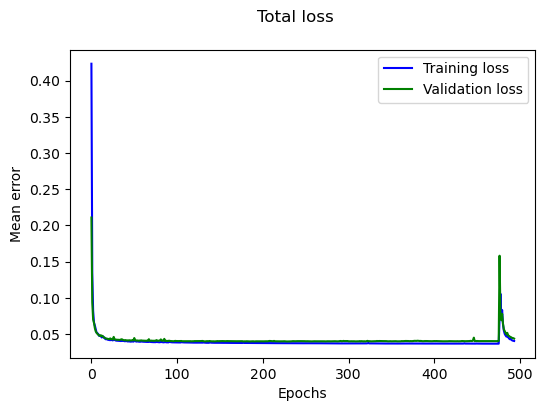

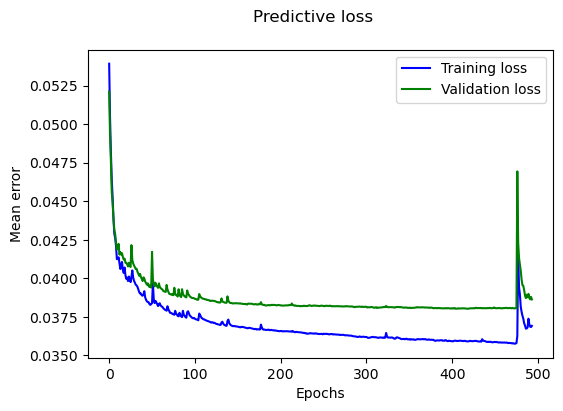

individual tasks:


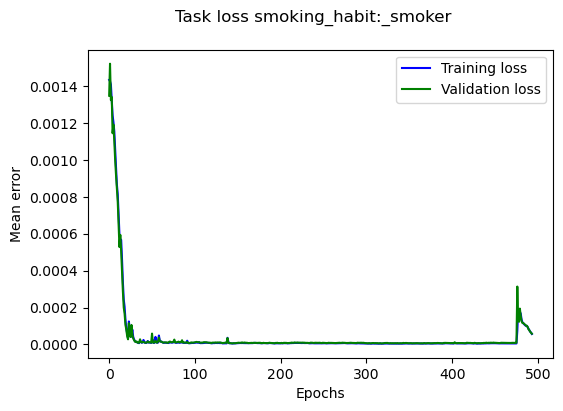

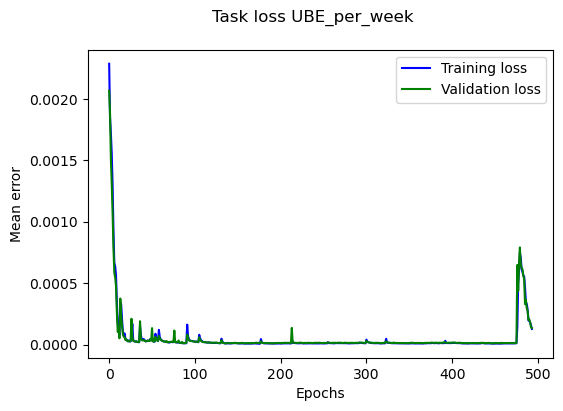

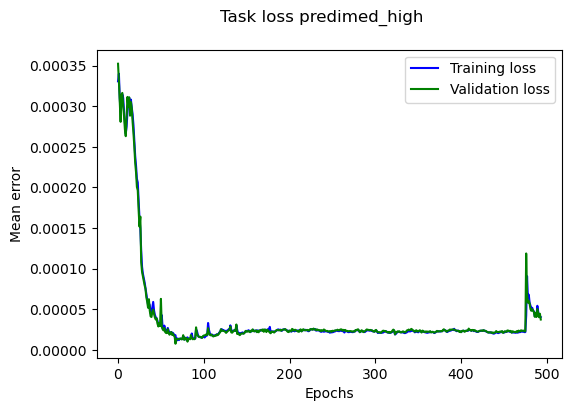

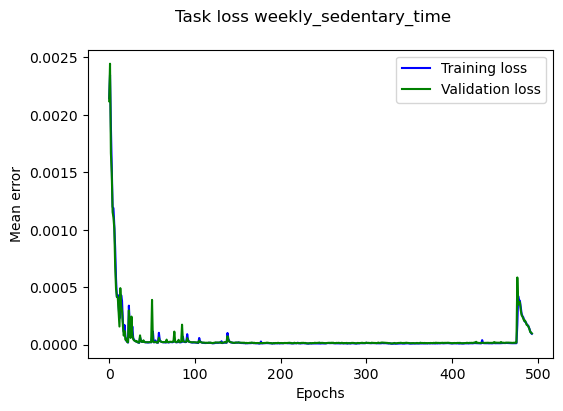

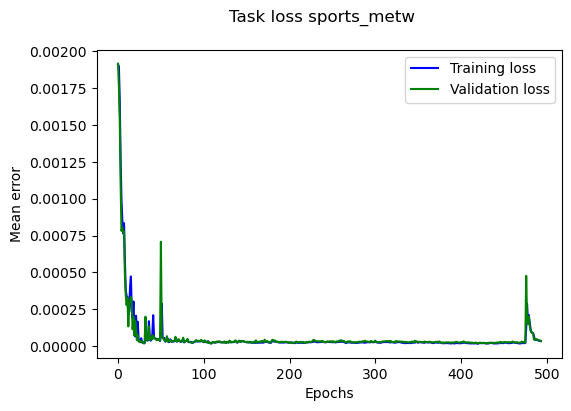

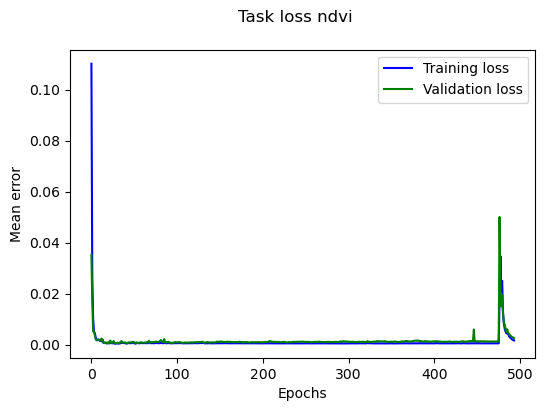

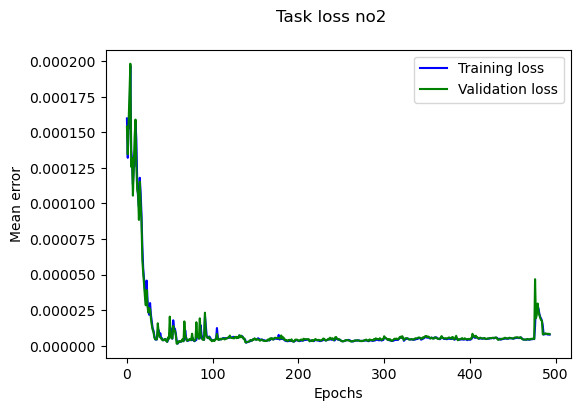

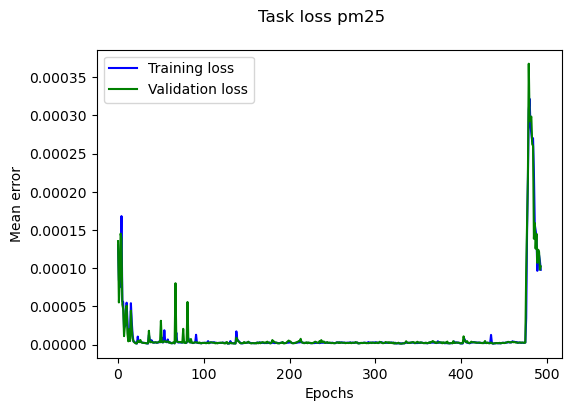

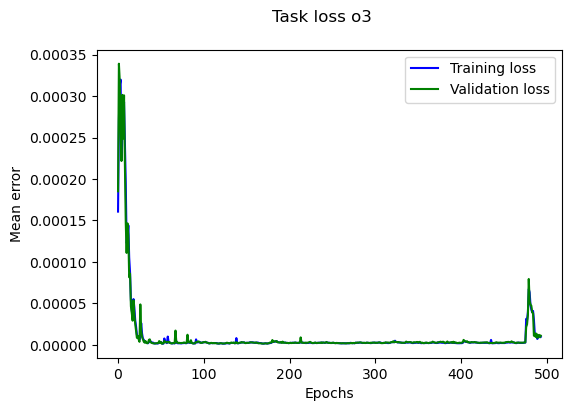

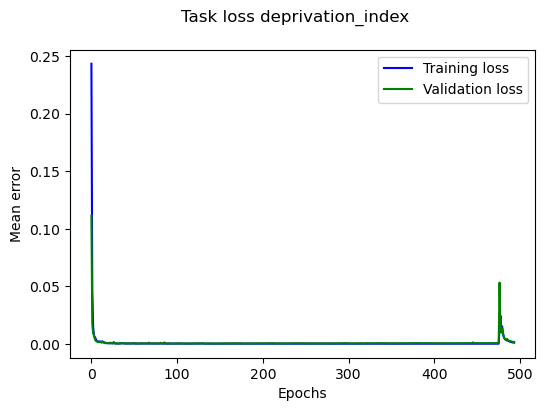

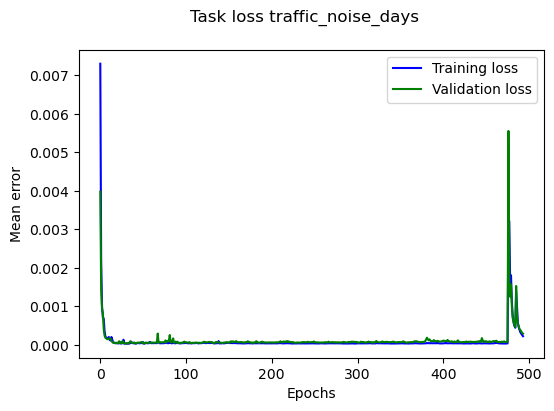

MLP accuracy: 0.7517259691980882 :  ROC AUC: 0.6969249819574586
Precision: 0.5619047619047619 Recall: 0.06223628691983123
0.0    3661
1.0     105
dtype: int64
CPU times: user 13h 32s, sys: 1h 16min 39s, total: 14h 17min 12s
Wall time: 53min 39s


In [566]:
%%time
# Perform litterature constrained training
train_dataloader = make_dataloader(std_X_train, y_train, dtype=torch.float64)
valid_dataloader = make_dataloader(std_X_valid, y_valid, dtype=torch.float64)
test_dataloader = make_dataloader(std_X_test, y_test, dtype=torch.float64)

set_seed(0)
seann = LogSEANN(n_features=len(std_X_train.columns),
                 initial_size_multiplier=best_params['initial_size_multiplier'], 
                 n_hidden_layers=best_params['n_hidden_layers'],
                 size_decrease_multiplier=best_params['size_decrease_multiplier'],
                 constraints = constraints,
                 rescale_loss_weight = predictive_weight,
                                ).double().to(device)

optimizer = torch.optim.Adam(seann.parameters(), lr = 1.5e-3)
train_custom_model(seann, alternative_custom_loss_or, optimizer, train_dataloader, valid_dataloader, device, 
                   epochs=500,
                   patience=20,
                   early_stopping=True,
                   verbose=False)

pred_probas = predict(test_dataloader, seann, device)
auc = roc_auc_score(y_test, pred_probas)
accuracy = accuracy_score(y_test, pred_probas.round())
print(f"MLP accuracy:", accuracy, ":  ROC AUC:", auc)
print("Precision:", precision_score(y_test, pred_probas.round()), "Recall:", recall_score(y_test, pred_probas.round()))
dist = pd.Series(pred_probas.round()).value_counts()
print(dist)

In [78]:
# computes standardization weights. Puts each term into the same scale.
weights = linear_normalize(list(pes_sample_sizes.values()))
initial_scaling_weights = {'data': 1}
for i, key in enumerate(pes_sample_sizes.keys()):
    initial_scaling_weights[key] = weights[i]
standard_weights = compute_scaling_weights_binary_classif(std_X_train, y_train, indexes, effect_sizes,  step_sizes)

results = {}
importance_mults = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.50, 0.60, 0.80, 0.9, 1.0]
for imp in importance_mults:
    scaling_weights = initial_scaling_weights
    scaling_weights['data'] = imp
    adjusted_lambdas = [list(scaling_weights.values())[i]*standard_weights[i] for i in range(len(standard_weights))]
    print(adjusted_lambdas)
    constraints = create_constraints(indexes, effect_sizes, step_sizes, adjusted_lambdas[1:], name_list, verbose=False)
    print(f"Training model with relative data importance factor: {scaling_weights['data']}")
    # train model
    set_seed(0)
    seann = LogSEANN(n_features=len(std_X_train.columns),
                     initial_size_multiplier=best_params['initial_size_multiplier'], 
                     n_hidden_layers=best_params['n_hidden_layers'],
                     size_decrease_multiplier=best_params['size_decrease_multiplier'],
                     constraints = constraints,
                     rescale_loss_weight = adjusted_lambdas[0],
                                    ).double().to(device)

    optimizer = torch.optim.Adam(seann.parameters(), lr = 1.5e-3)
    train_custom_model(seann, alternative_custom_loss_or, optimizer, train_dataloader, valid_dataloader, device, 
                       epochs=500,
                       patience=20,
                       early_stopping=True,
                       plot=False,
                       verbose=False)
    print("Training completed!\n")
    # compute prediction AUC
    pred_probas = predict(test_dataloader, seann, device)
    auc = roc_auc_score(y_test, pred_probas)
    # compute mean delta shap
    wrapped_model = ModelWrapper(seann) 
    explainer = shap.DeepExplainer(wrapped_model, background_tensor)
    sv = explainer.shap_values(background_tensor)
    delta_shap = {}
    for i, name in enumerate(pes.keys()):
        delta_shap[name] = mean_absolute_error(true_shap_values[name], sv[:, i])
    mean_delta_shap = np.mean(list(delta_shap.values()))
    results[imp] = [auc, mean_delta_shap]
    print(results)
print(results)

[0.014426950408889635, 79.63341650924356, 24.435777191561105, 166.21188963346742, 1088.125194865825, 1735.7510674644866, 1806265.3304848021, 1.2068209060119537, 9.210122374527876, 2.929831932880845, 66399.44862822581, 599752.002967541]
Training model with relative data importance factor: 0.01
Training completed!

{0.01: [0.6114864359018126, 0.033702881963783814]}
[0.02885390081777927, 79.63341650924356, 24.435777191561105, 166.21188963346742, 1088.125194865825, 1735.7510674644866, 1806265.3304848021, 1.2068209060119537, 9.210122374527876, 2.929831932880845, 66399.44862822581, 599752.002967541]
Training model with relative data importance factor: 0.02
Training completed!

{0.01: [0.6114864359018126, 0.033702881963783814], 0.02: [0.6384252230237802, 0.034185860476828145]}
[0.0432808512266689, 79.63341650924356, 24.435777191561105, 166.21188963346742, 1088.125194865825, 1735.7510674644866, 1806265.3304848021, 1.2068209060119537, 9.210122374527876, 2.929831932880845, 66399.44862822581, 599

In [385]:
def SEANN_benchmarch(alphas:list, omegas:list, gamma:float, results:dict):
    indexes = list(pes_indexes.keys())
    if gamma not in results.keys(): 
        predictive_weight = alphas[0] * gamma
        constraints_weights = [alphas[i+1] * omegas[i] * (1-gamma) for i in range(len(omegas))]
        constraints = create_constraints(indexes, effect_sizes, step_sizes, constraints_weights, name_list, verbose=False)
        print(f"Training model with relative data importance factor: {gamma}")
        set_seed(0)
        seann = LogSEANN(n_features=len(std_X_train.columns),
                         initial_size_multiplier=best_params['initial_size_multiplier'], 
                         n_hidden_layers=best_params['n_hidden_layers'],
                         size_decrease_multiplier=best_params['size_decrease_multiplier'],
                         constraints = constraints,
                         rescale_loss_weight = predictive_weight,
                                        ).double().to(device)

        optimizer = torch.optim.Adam(seann.parameters(), lr = 1.5e-3)
        train_custom_model(seann, alternative_custom_loss_or, optimizer, train_dataloader, valid_dataloader, device, 
                           epochs=500,
                           patience=20,
                           early_stopping=True,
                           plot=False,
                           verbose=False)
        print("Training completed!\n")
        # compute prediction AUC
        pred_probas = predict(test_dataloader, seann, device)
        auc = roc_auc_score(y_test, pred_probas)
        # compute mean delta shap
        from library import ModelWrapper # reimport each time to prevent a bug 
        wrapped_model = ModelWrapper(seann) 
        explainer = shap.DeepExplainer(wrapped_model, background_tensor)
        sv = explainer.shap_values(background_tensor)
        delta_shap = {}
        for i, name in enumerate(pes.keys()):
            delta_shap[name] = mean_absolute_error(true_shap_values[name], sv[:, indexes[i]])
        mean_delta_shap = np.mean(list(delta_shap.values()))
        results[gamma] = [auc, mean_delta_shap]
        print(results[gamma])
    return results

omegas = linear_normalize(list(pes_sample_sizes.values()))
standard_weights = compute_scaling_weights_binary_classif(std_X_train, y_train, indexes, effect_sizes,  step_sizes)
importance_mults = [0.003, 0.95, 0.0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.01, 0.02, 0.06, 0.07, 0.08, 0.09, 0.005, 0.03, 0.04, 0.045, 0.001]
res = {}
for imp in importance_mults:
    res = SEANN_benchmarch(standard_weights, omegas, imp, res)

Training model with relative data importance factor: 0.003
Training completed!

[0.6569491484818811, 0.0005960843566986426]
Training model with relative data importance factor: 0.95
Training completed!

[0.7025522335318761, 0.004055698926521878]
Training model with relative data importance factor: 0.0
Training completed!

[0.5300131313766534, 0.000587004660268631]
Training model with relative data importance factor: 0.025
Training completed!

[0.6892213408078867, 0.0007133311074636116]
Training model with relative data importance factor: 0.05
Training completed!

[0.6977788209011989, 0.0008029892512677839]
Training model with relative data importance factor: 0.075
Training completed!

[0.6957915210536245, 0.0008988830641795173]
Training model with relative data importance factor: 0.1
Training completed!

[0.6971735348108753, 0.0009784667168541055]
Training model with relative data importance factor: 0.15
Training completed!

[0.6980891376413831, 0.0011363664273962187]
Training model wi

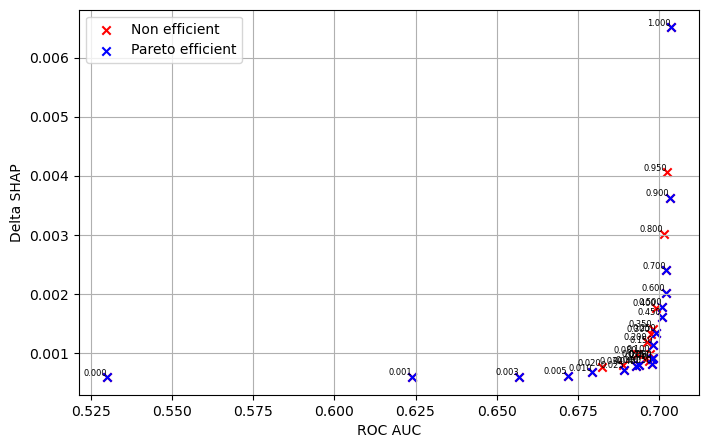

In [ ]:
# pareto front plot
aucs = [res[key][0] for key in res]
deltas_shap = [res[key][1] for key in res]
lambda_values = [key for key in res]

def is_pareto_efficient(costs, maximize):
    """
    Find the Pareto-efficient points
    :param costs: An (n_points, n_metrics) array
    :param maximize: Boolean array of same length as n_metrics indicating whether to maximize (True) or minimize (False) each metric
    :return: A boolean array of Pareto-efficient points
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            for j, other_c in enumerate(costs):
                if all(maximize * (other_c >= c) + ~maximize * (other_c <= c)) and i != j:
                    is_efficient[i] = False
                    break
    return is_efficient


# True for metrics we want to maximize, False for metrics we want to minimize
data = np.column_stack((aucs, deltas_shap))
maximize = np.array([True, False])  # Maximize ROC AUC, Minimize Delta SHAP

pareto_efficient = is_pareto_efficient(data, maximize)
pareto_points = data[pareto_efficient]

plt.figure(figsize=(8, 5))
plt.scatter(data[:, 0], data[:, 1], color='red', label='Non efficient', marker='x')
plt.scatter(pareto_points[:, 0], pareto_points[:, 1], color='blue', label='Pareto efficient', marker='x')
for i, (x, y) in enumerate(data):
    # Annotating each point with its lambda value, adjust text position slightly for better visibility
    plt.text(x, y, f'{lambda_values[i]:.3f}', color='black', fontsize=6, ha='right', va='bottom')

for i, (x, y) in enumerate(pareto_points):
    # Find the index of the pareto point in the original data to get the correct lambda value
    original_index = np.where((data == [x, y]).all(axis=1))[0][0]
    # plt.text(x, y, f'{lambda_values[original_index]:.3f}', color='black', fontsize=8, ha='right', va='bottom')
# plt.title('Pareto Front with Several Efficient Solutions')
plt.xlabel('ROC AUC')
plt.ylabel('Delta SHAP')
plt.legend()
plt.grid(True)
plt.show()

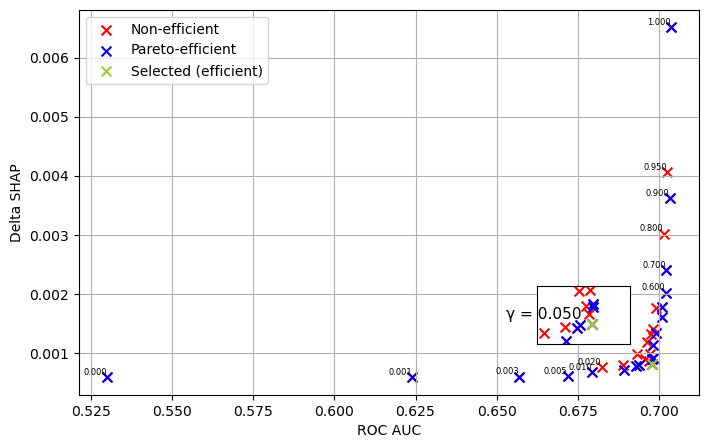

In [497]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Main plot
plt.figure(figsize=(8, 5))
plt.scatter(data[:, 0], data[:, 1], color='red', label='Non-efficient', marker='x', s=50)
plt.scatter(pareto_points[:, 0], pareto_points[:, 1], color='blue', label='Pareto-efficient', marker='x', s=50)

x_min, x_max = 0.685, 0.71
y_min, y_max = 0.0007, 0.002
for i, (x, y) in enumerate(data):
    if x < x_min or x > x_max or y < y_min or y > y_max:
        plt.text(x, y + 1e-5, f'{lambda_values[i]:.3f}', color='black', fontsize=6, ha='right', va='bottom')

optimal_point_label = 0.05
optimal_point_auc, optimal_point_dshap = res[optimal_point_label][0], res[optimal_point_label][1]
plt.scatter(optimal_point_auc, optimal_point_dshap, color='yellowgreen', label='Selected (efficient)', marker='x', s=50)
plt.xlabel('ROC AUC')
plt.ylabel('Delta SHAP')
plt.legend()
plt.grid(True)

# Inset plot (zoom)
axins = inset_axes(plt.gca(), width="15%", height="15%", bbox_to_anchor=(-0.1, -0.7, 1, 1), bbox_transform=plt.gca().transAxes)  # Lower right corner
axins.scatter(data[:, 0], data[:, 1], color='red', marker='x', s=50)
axins.scatter(pareto_points[:, 0], pareto_points[:, 1], color='blue', marker='x', s=50)
axins.set_xlim(0.68, 0.71)  # Set the x-limits for the zoom
axins.set_ylim(0.0007, 0.001)  # Set the y-limits for the zoom
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])

axins.text(optimal_point_auc - 0.0035, optimal_point_dshap + 1e-5, f'\u03B3 = {optimal_point_label:.3f}', color='black',
           fontsize=11,
           ha='right',
           va='bottom',
           # fontweight='bold'
          )
axins.scatter(optimal_point_auc, optimal_point_dshap, color='yellowgreen', marker='x', s=50)
plt.grid(True)
plt.show()

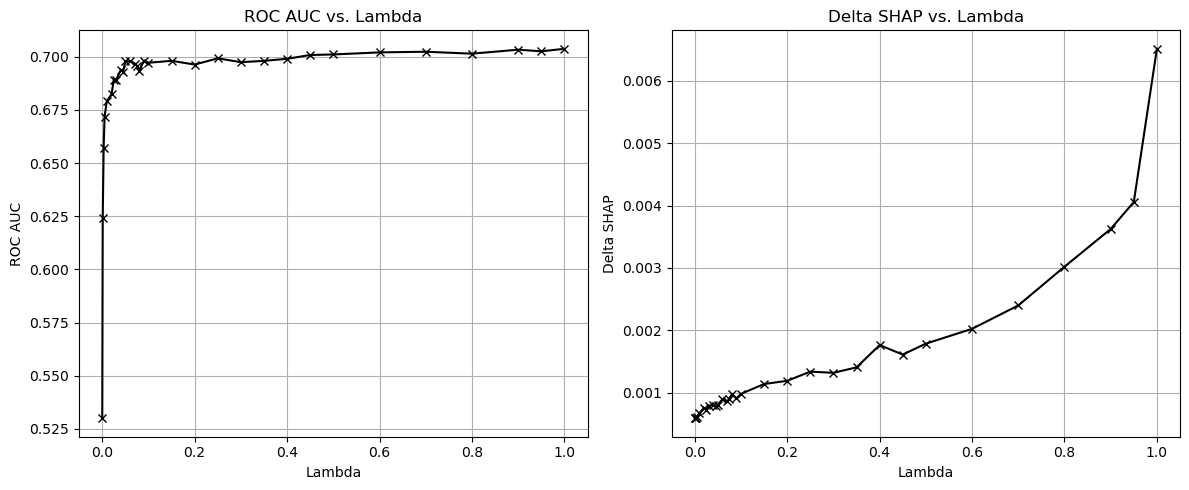

In [388]:
# Sort data by lambda values for plotting
sorted_indices = np.argsort(lambda_values)
lambda_values_sorted = np.array(lambda_values)[sorted_indices]
roc_auc_sorted = np.array(aucs)[sorted_indices]
delta_shap_sorted = np.array(deltas_shap)[sorted_indices]

# Plot ROC AUC vs. lambda
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(lambda_values_sorted, roc_auc_sorted, marker='x', linestyle='-', color='black')
plt.title('ROC AUC vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('ROC AUC')
plt.grid(True)

# Plot Delta SHAP vs. lambda
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(lambda_values_sorted, delta_shap_sorted, marker='x', linestyle='-', color='black')
plt.title('Delta SHAP vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Delta SHAP')
plt.grid(True)

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [ ]:
# compute shapley values for SEANN
from library import ModelWrapper # reimport to prevent bug
wrapped_model = ModelWrapper(seann) 
explainer = shap.DeepExplainer(wrapped_model, background_tensor)
seann_shap_values = explainer.shap_values(background_tensor)

In [ ]:
def compute_delta_shap():
    shapley_values_1_df = pd.DataFrame(shapley_values_1, columns=inputs.columns)

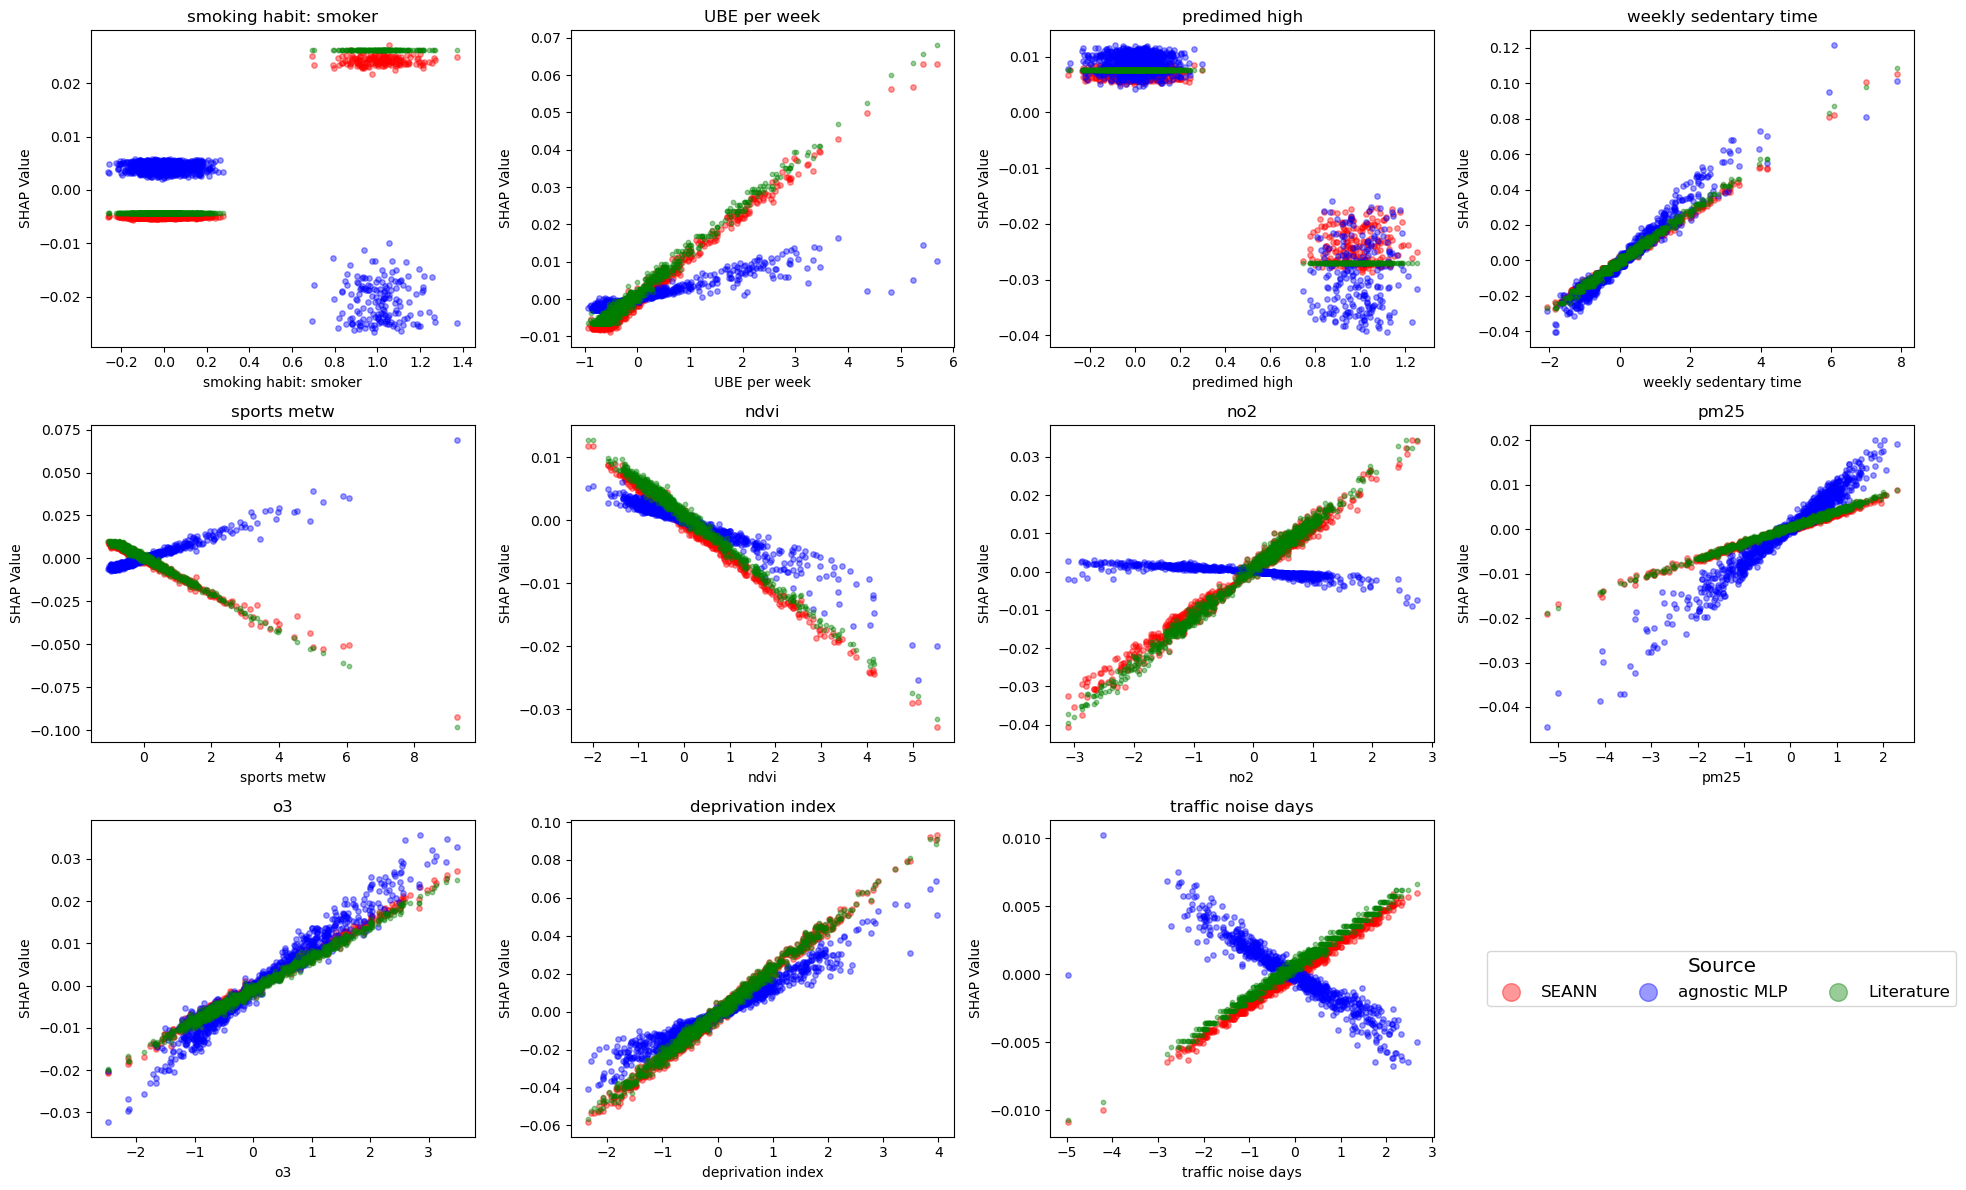

In [526]:
compare_deepshap_dashboard(seann_shap_values, mlp_shap_values,
                           "SEANN",
                           "agnostic MLP",
                           inputs,
                           pes.keys(),
                           true_shap_values,
                           jitter=0.1, layout_n_cols=4, save_file_name="constrained_marginal_effects")

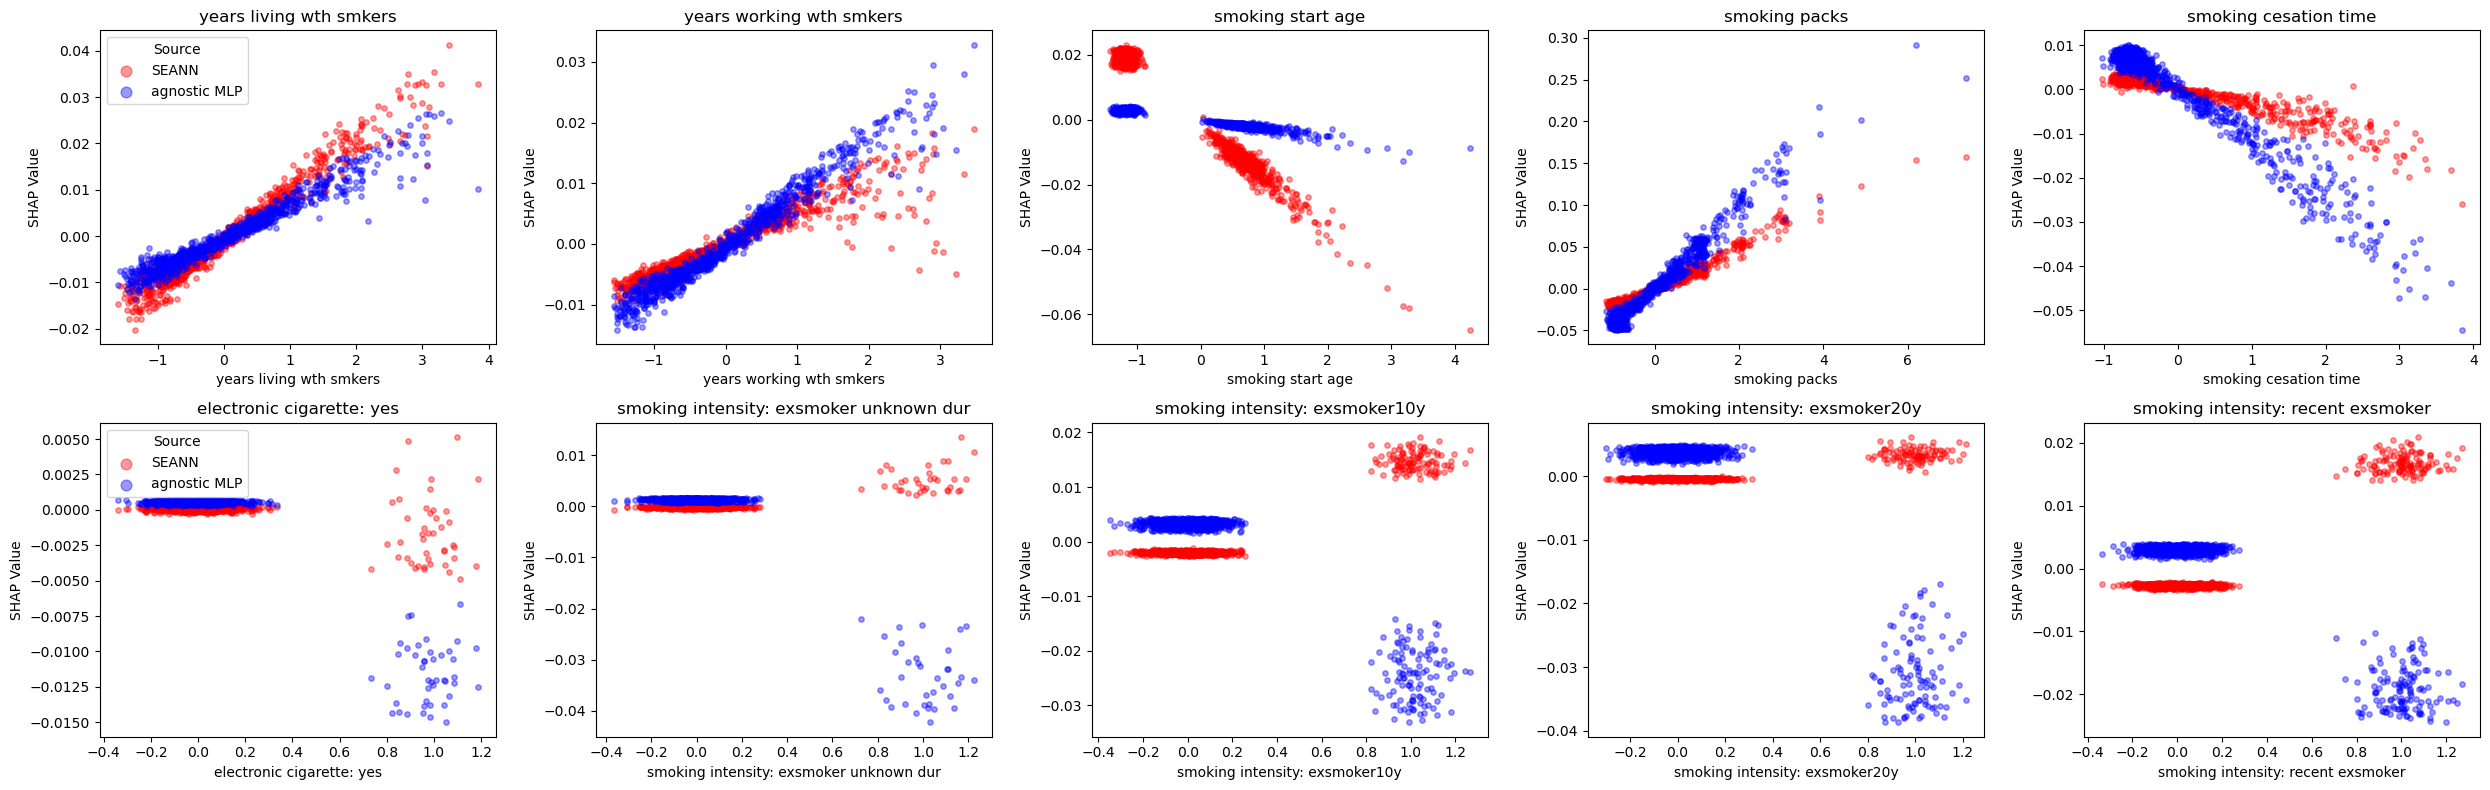

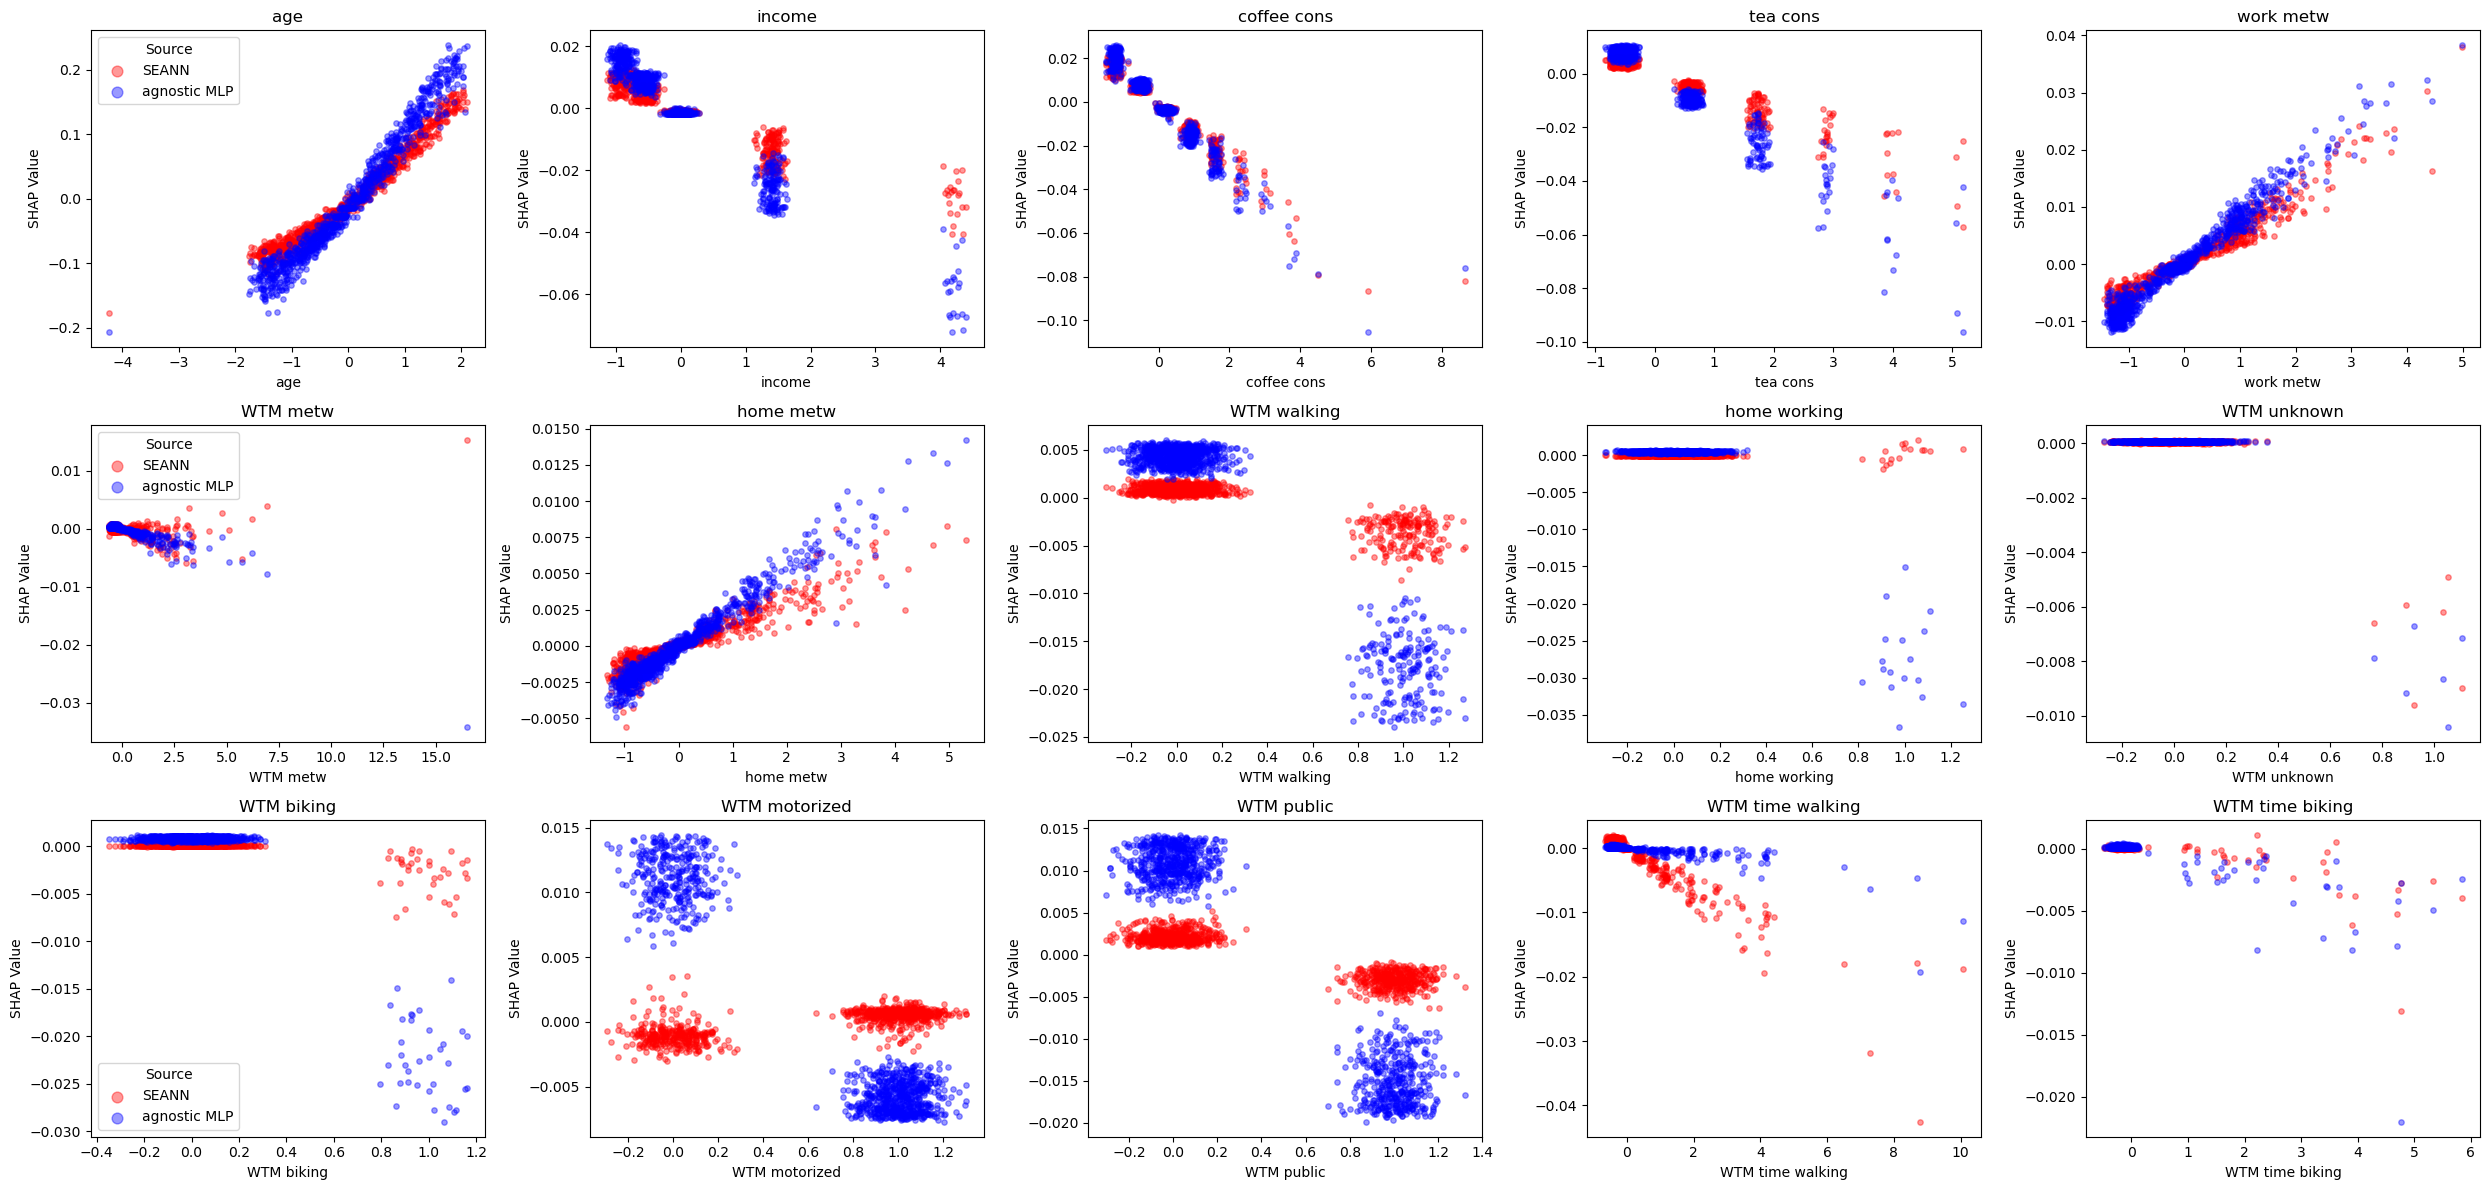

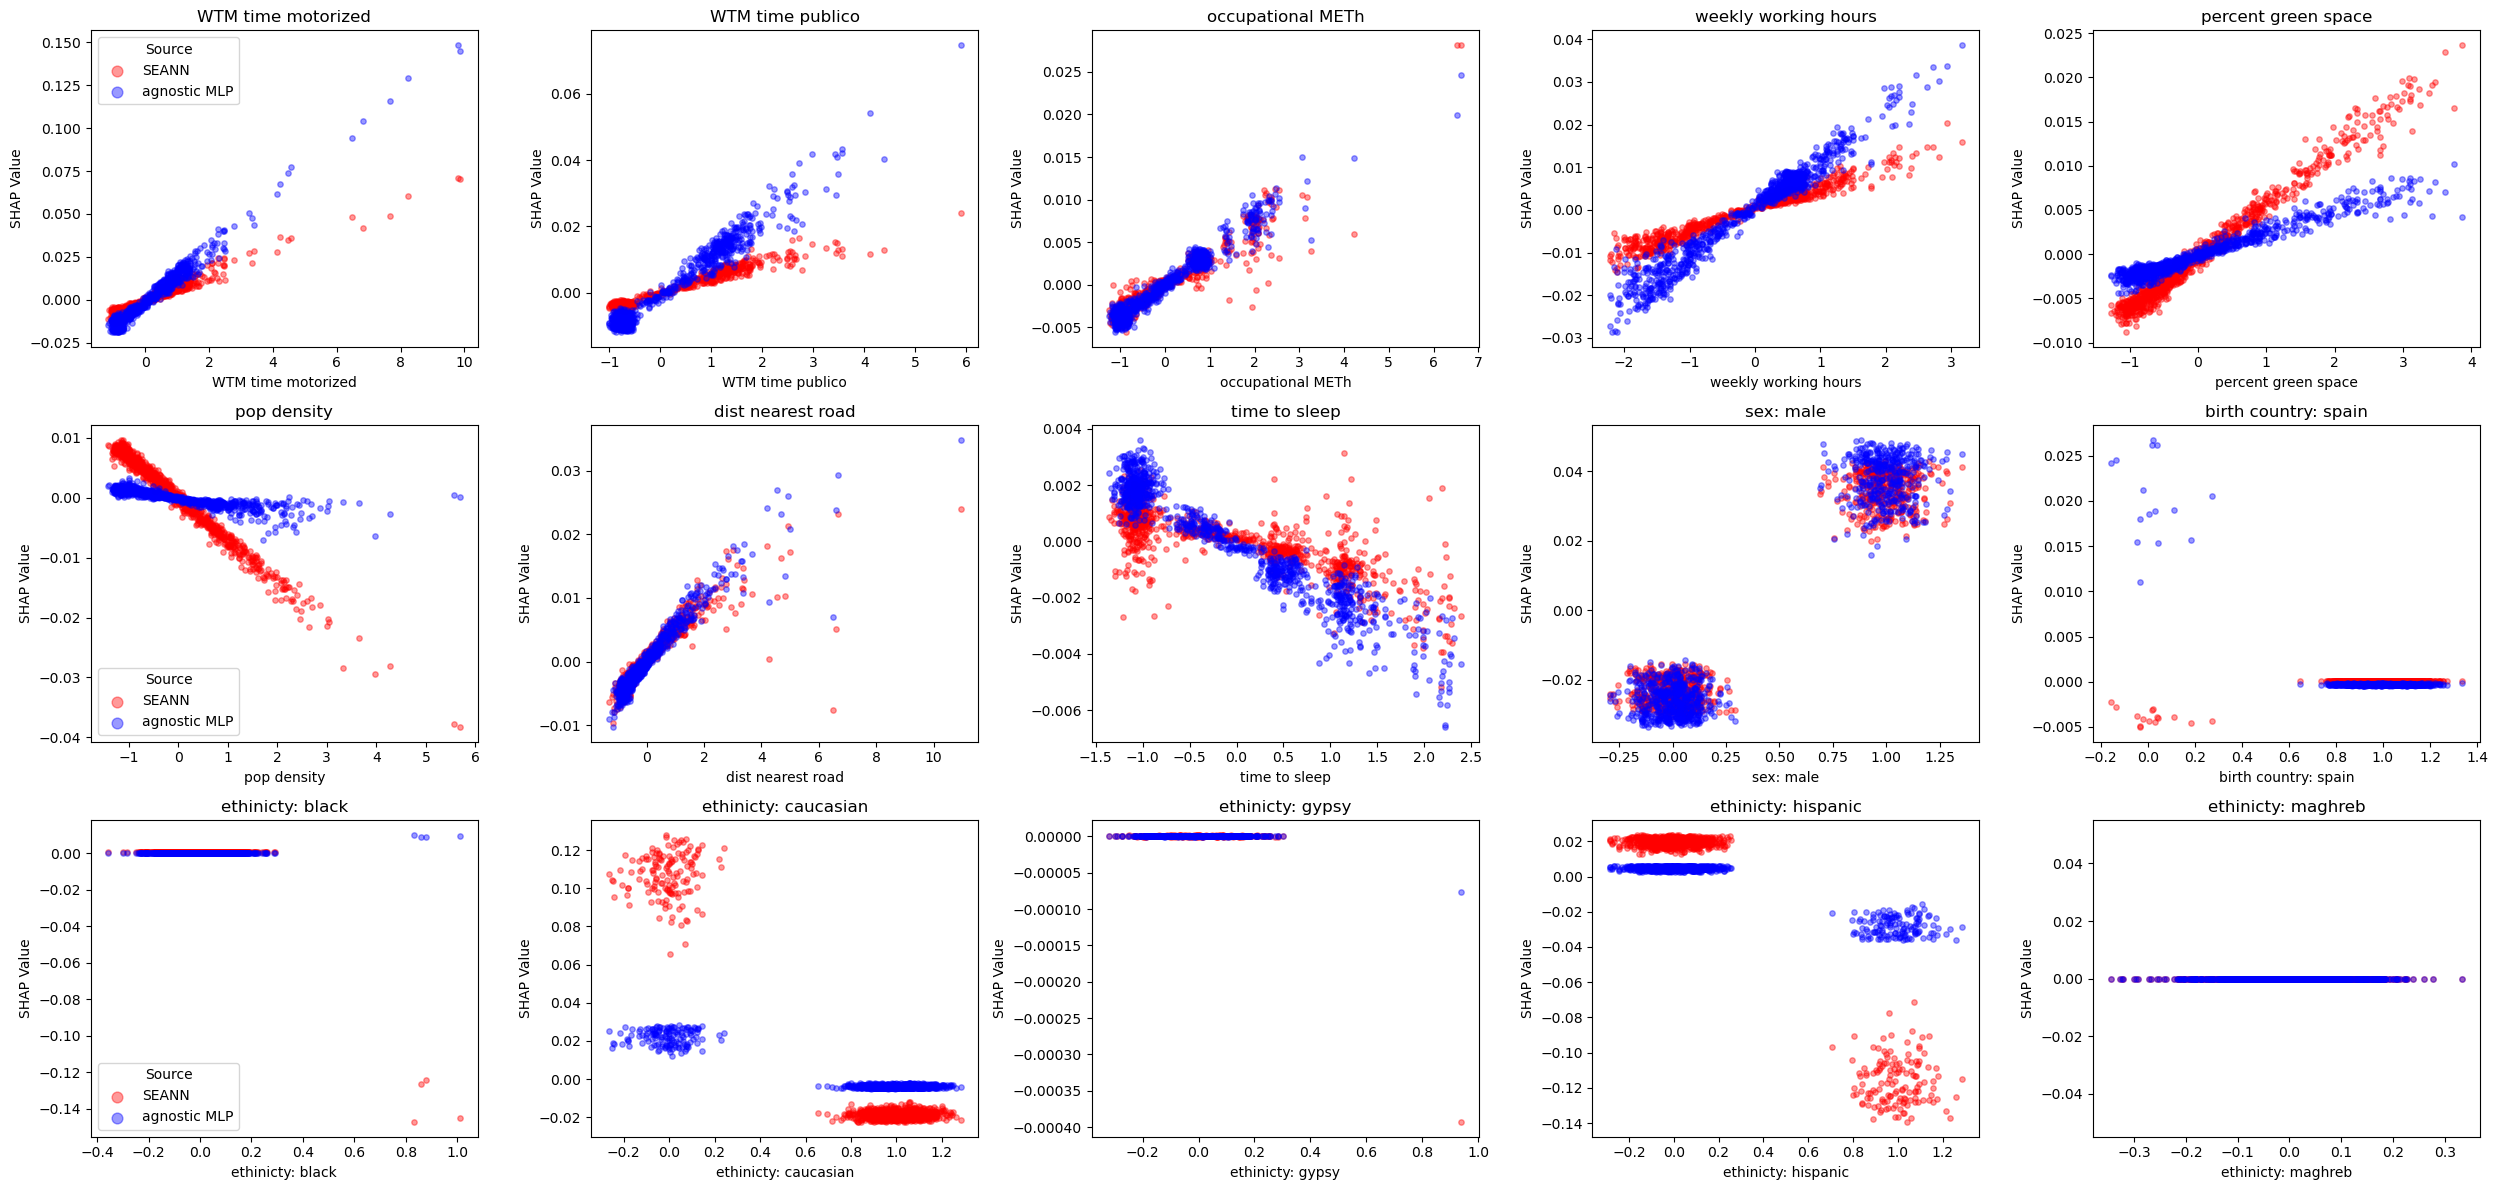

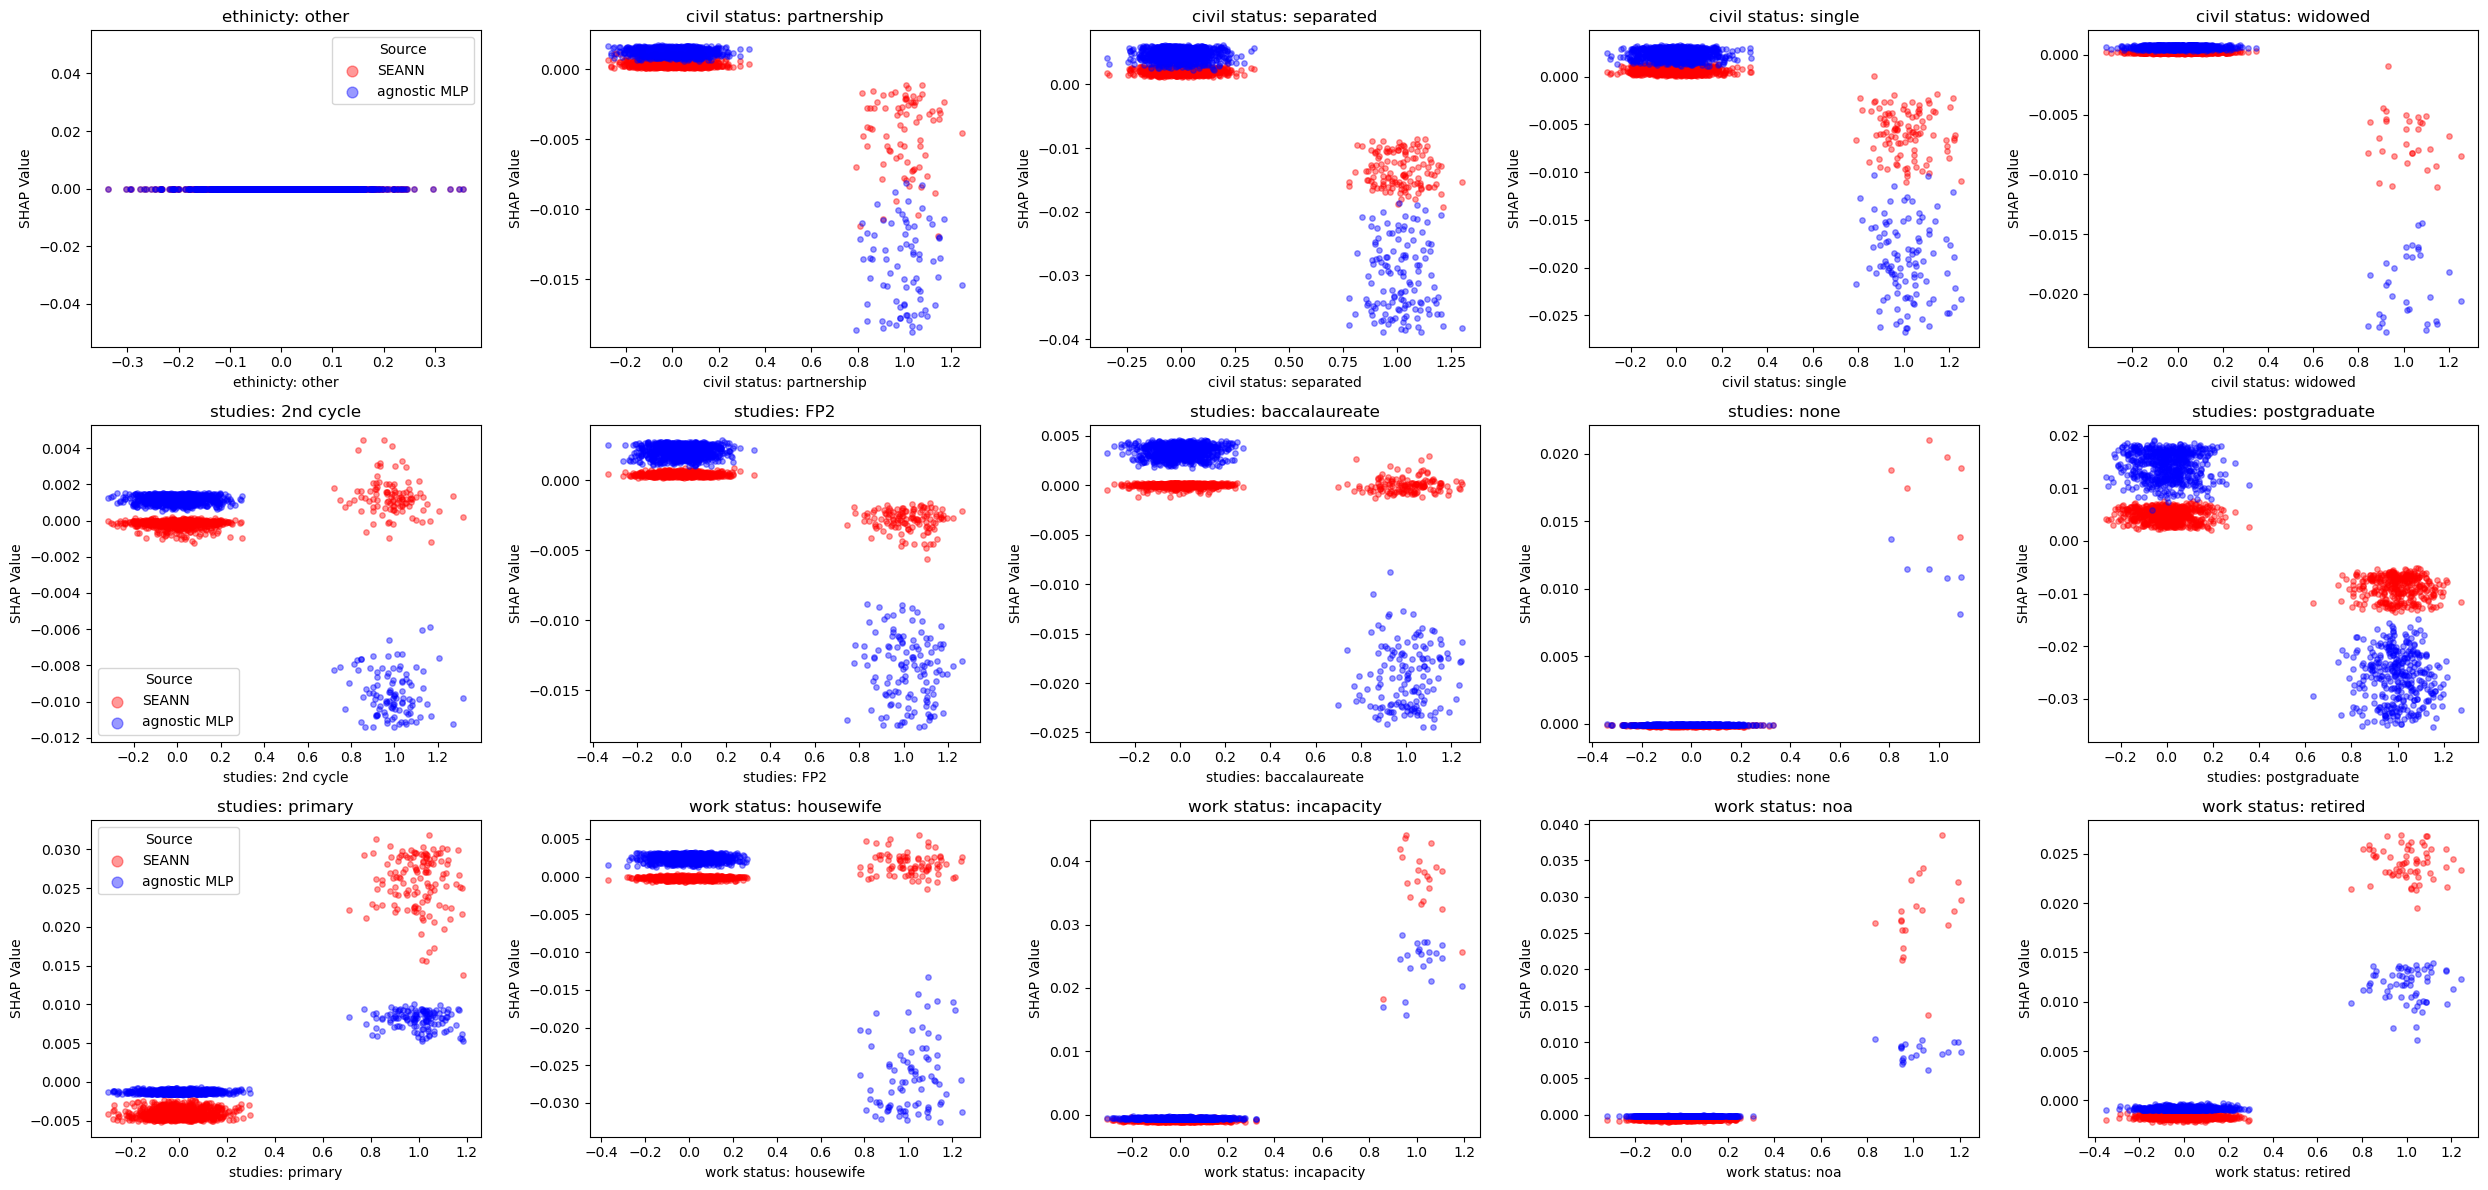

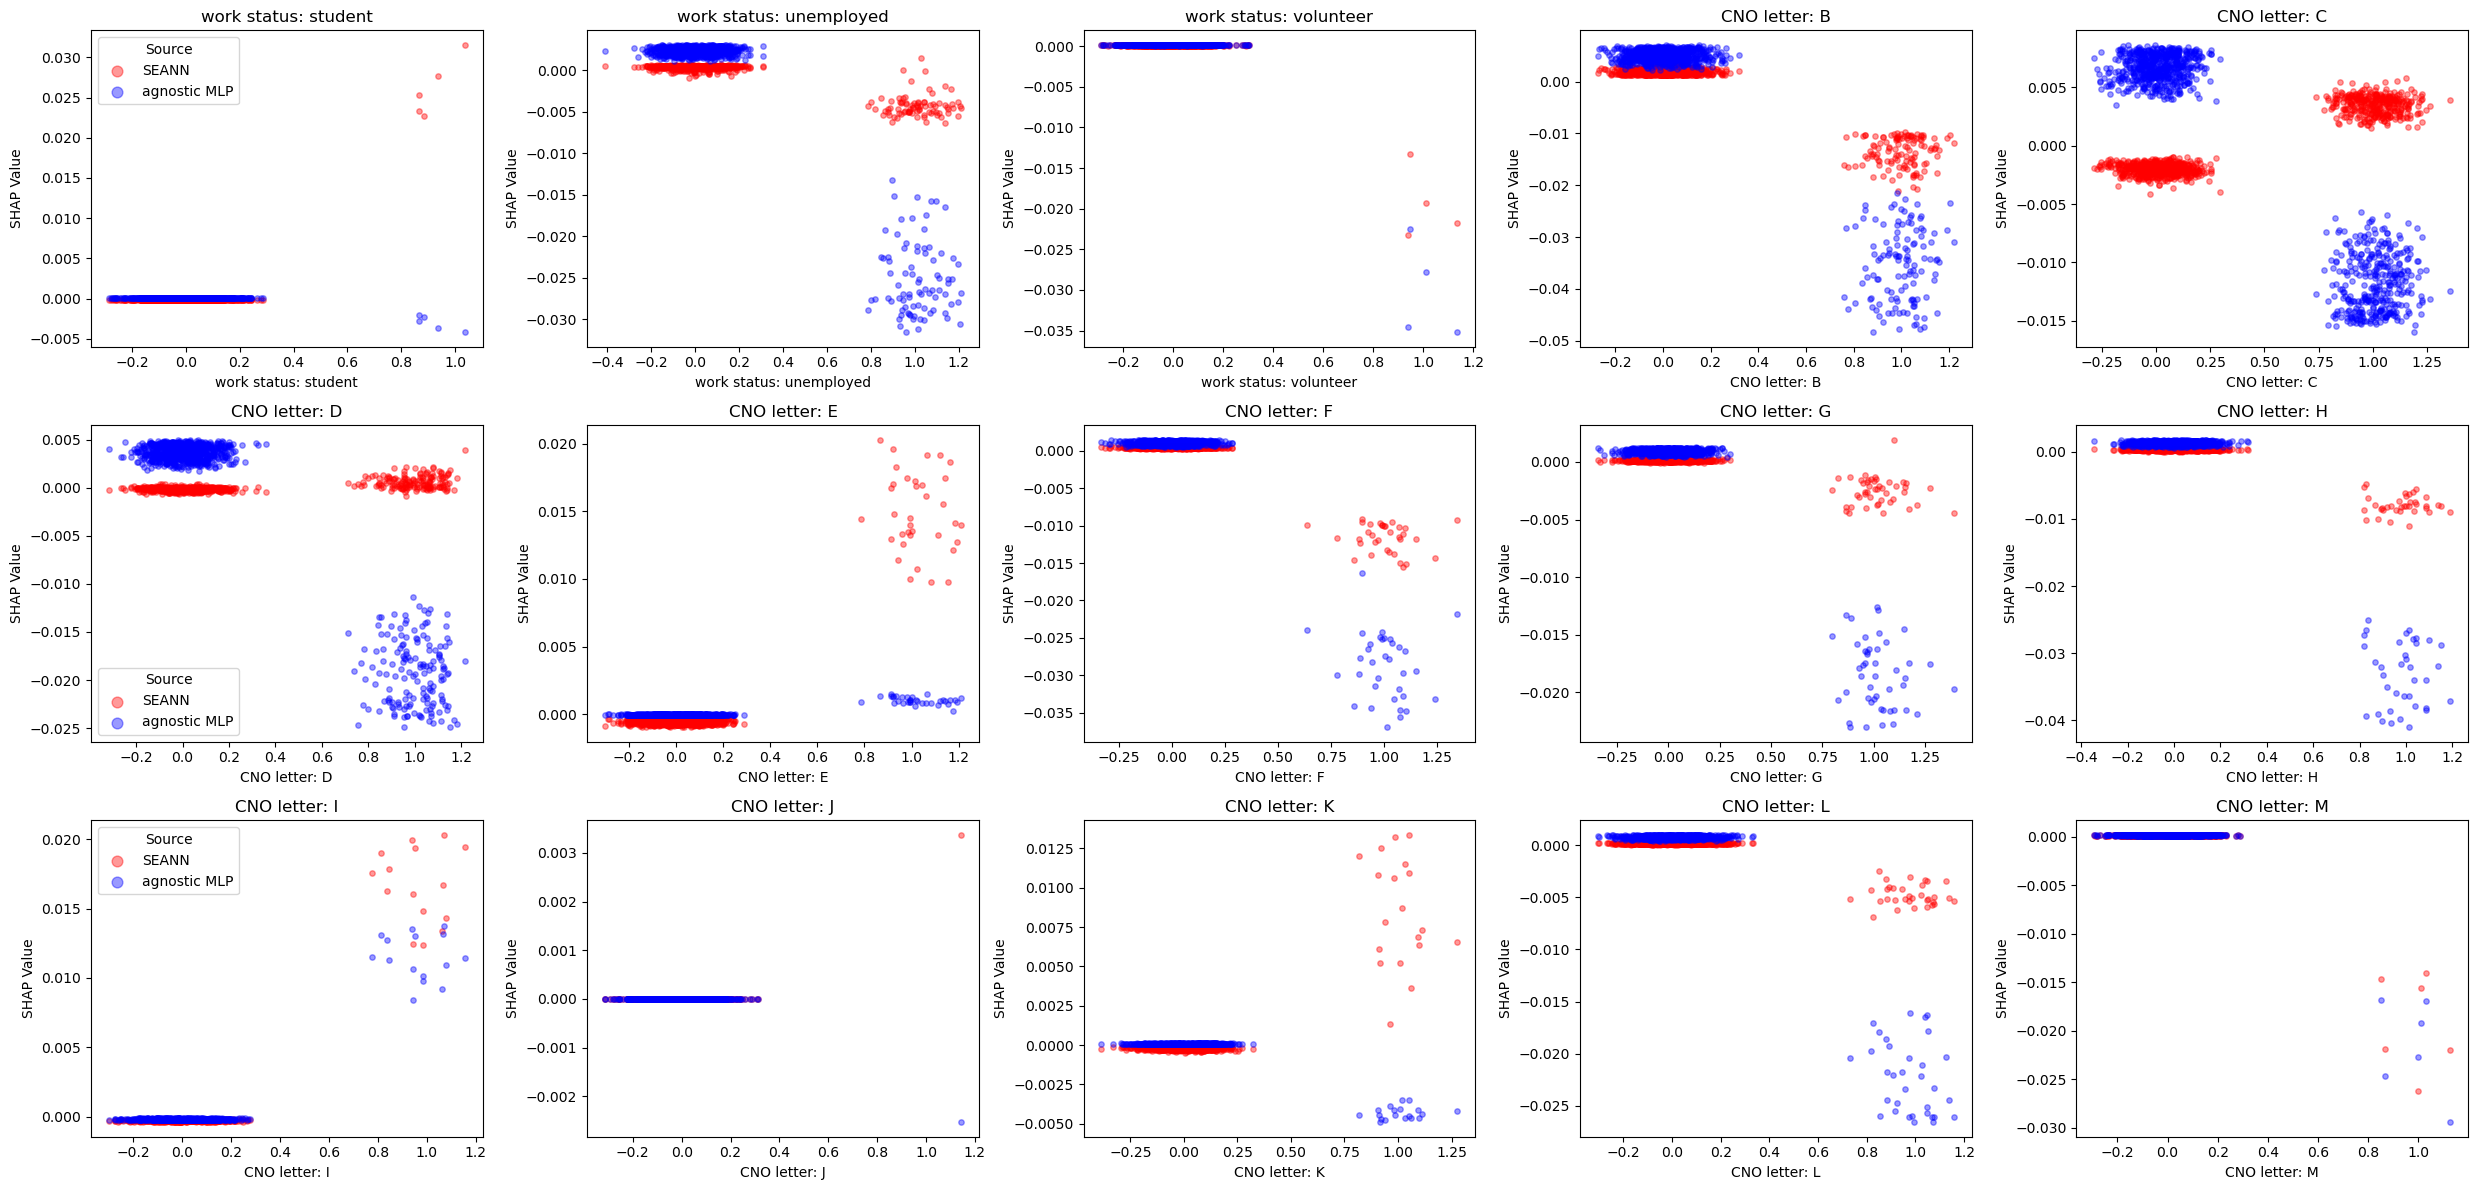

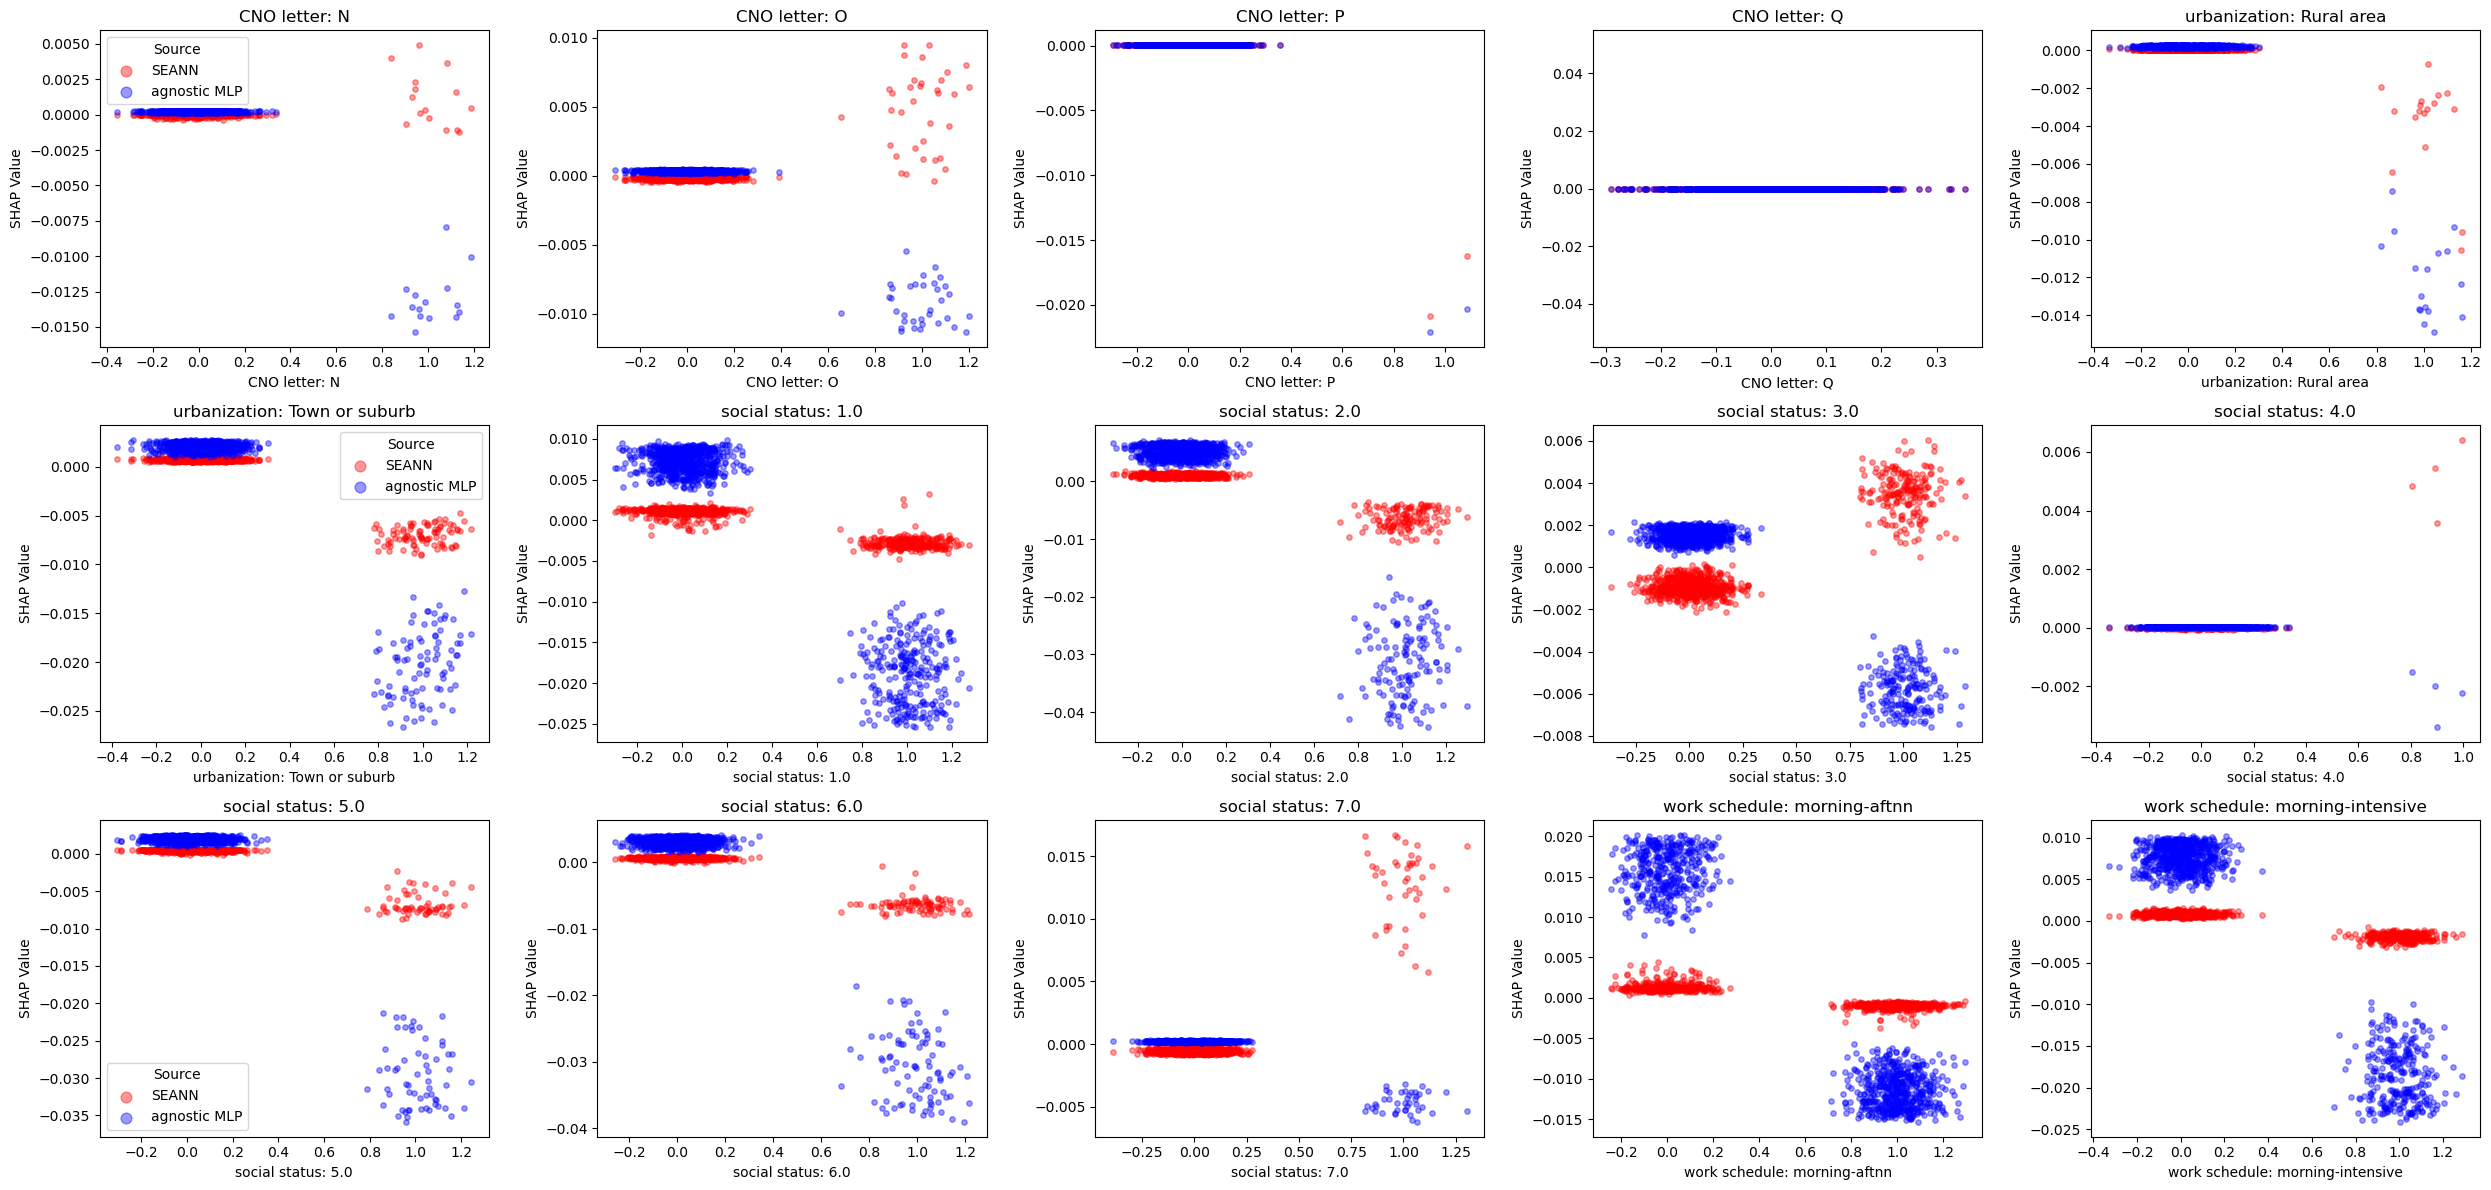

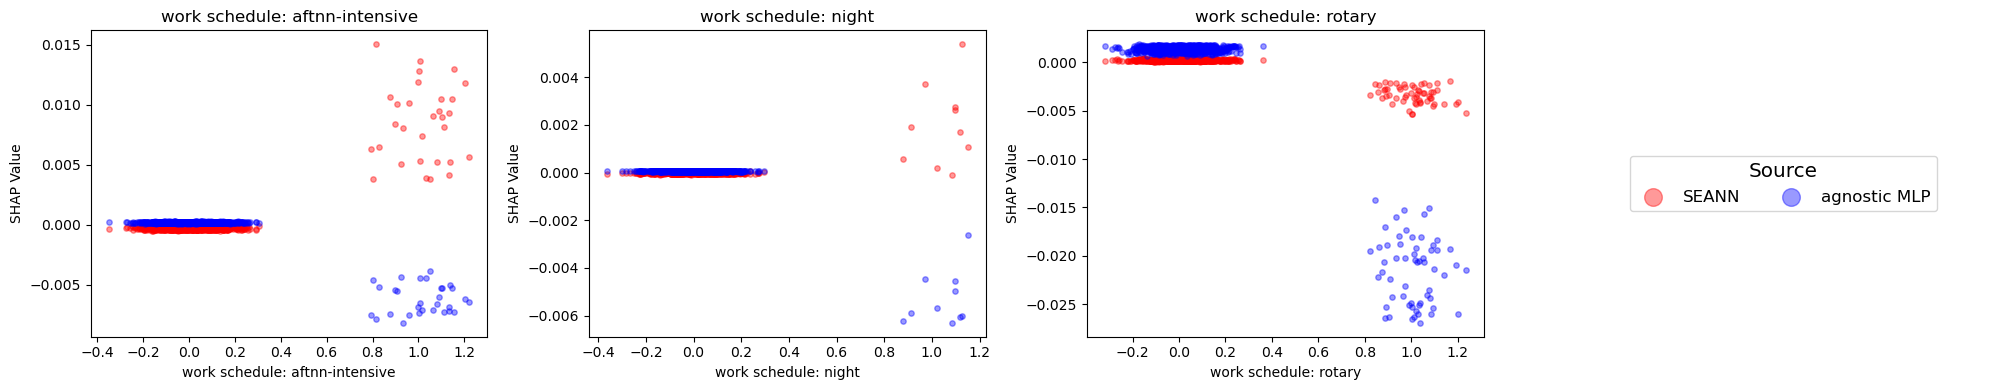

In [524]:
non_constrained_columns = [column for column in inputs.columns if column not in pes.keys()]
smoking_vars = ['years_living_wth_smkers', 'years_working_wth_smkers', 'smoking_start_age', 'smoking_packs', 'smoking_cesation_time', 
                'electronic_cigarette:_yes', 'smoking_intensity:_exsmoker', 'smoking_intensity:_exsmoker10y', 'smoking_intensity:_exsmoker20y', 'smoking_intensity:_recent_exsmoker']
compare_deepshap_dashboard(seann_shap_values, mlp_shap_values,
                           "SEANN",
                           "agnostic MLP",
                           inputs,
                           smoking_vars,
                           jitter=0.1,
                           layout_n_cols=5, save_file_name="smoking_marginal_effects")
remaining_vars = [col for col in non_constrained_columns if col not in smoking_vars]
split_lenght = 15
for i in range(0, len(remaining_vars), split_lenght):
    subset = remaining_vars[i:i+split_lenght]
    compare_deepshap_dashboard(seann_shap_values, mlp_shap_values,
                           "SEANN",
                           "agnostic MLP",
                           inputs,
                           subset,
                           jitter=0.1,
                           layout_n_cols=5, save_file_name=f"nnconstrained_marginal_effects_{i}-{i+split_lenght}")